# WT vs $\Delta$DEK1

In [1]:
library(sleuth)
library(splines)
library(scales)

Loading required package: ggplot2
Loading required package: dplyr

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
#https://stackoverflow.com/questions/41849951/using-ggplot-geo-geom-histogram-with-y-log-scale-with-zero-bins
mylog10_trans <- function (base = 10) 
{
  trans <- function(x) log(x + 1, base)
  inv <- function(x) base^x
  trans_new(paste0("log-", format(base)), trans, inv, log_breaks(base = base), 
            domain = c(1e-100, Inf))
}

In [3]:
d=read.delim("../kallisto/sample_descriptions/our_data.txt",sep="\t",stringsAsFactors=FALSE)
names(d)[1:2]=c("sample","sample_alias")
d$batch=as.numeric(gsub("^[^-]+-[^-]+-[^-]+-(\\d+$)$","\\1",gsub("([A-z]+)(\\d+)","\\1-\\2",d$sample,perl=TRUE),perl=TRUE))
d$batch[is.na(d$batch)]=1
table(d$batch)
d$harvest=sprintf("%id_b%i",d$Time,d$batch)
table(d$harvest)
head(d)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


 1  2  3 
24 25 25 


12d_b1 12d_b2 12d_b3 14d_b1 14d_b2 14d_b3  3d_b1  3d_b2  3d_b3  5d_b1  5d_b2 
     5      5      5      5      5      5      4      5      5      5      5 
 5d_b3  9d_b1  9d_b2  9d_b3 
     5      5      5      5 

sample,sample_alias,Group,GT,Time,elongation_caulonema,protonemata_branching,number_buds_per_filament,percents_filaments_with_buds,gametophore_formation,colony_size,rhizoid_formation,development_of_phyllids,batch,harvest
1-W3,1.W3,1,WT,3,normal,normal,absent,absent,absent,normal,absent,absent,1,3d_b1
2-W3-2,2.W3.2,1,WT,3,normal,normal,absent,absent,absent,normal,absent,absent,2,3d_b2
3-W3-3,3.W3.3,1,WT,3,normal,normal,absent,absent,absent,normal,absent,absent,3,3d_b3
4-D3,4.D3,2,deltaDEK,3,normal,normal,absent,absent,absent,normal,absent,absent,1,3d_b1
5-D3-2,5.D3.2,2,deltaDEK,3,normal,normal,absent,absent,absent,normal,absent,absent,2,3d_b2
6-D3-3,6.D3.3,2,deltaDEK,3,normal,normal,absent,absent,absent,normal,absent,absent,3,3d_b3


In [4]:
#outlier replicates
exclude=d$sample[grep("5-3$",d$sample,perl=TRUE)]

In [5]:
d=subset(d,! sample %in% exclude )

In [6]:
table(d$GT,d$Time)

          
           3 5 9 12 14
  deltaDEK 3 2 3  3  3
  LG3      3 2 3  3  3
  Loop     3 2 3  3  3
  OE       2 2 3  3  3
  WT       3 2 3  3  3

In [7]:
table(file.exists(sprintf("../kallisto/kallisto/%s/abundance.h5",d$sample)))


TRUE 
  69 

In [8]:
d$path=sprintf("../kallisto/kallisto/%s/abundance.h5",d$sample)

In [9]:
m=read.delim("../analysis/cosmoss_V3.3.mRNA_ncRNA.tx2gene.full.tsv",stringsAsFactors=FALSE)
names(m)[1]="target_id"
m$class=ifelse(is.na(m$class),m$TYPE,m$class)
m$gene=paste(m$GENEID,m$class,sep=".")
m=m[,c("target_id","gene","class","TYPE")]
nrow(m)
head(m)

[1] 93962

target_id,gene,class,TYPE
Pp3c1_20V3.1,Pp3c1_20.mRNA,mRNA,mRNA
Pp3c1_20V3.2,Pp3c1_20.mRNA,mRNA,mRNA
Pp3c1_40V3.2,Pp3c1_40.mRNA,mRNA,mRNA
Pp3c1_40V3.1,Pp3c1_40.mRNA,mRNA,mRNA
Pp3c1_50V3.2,Pp3c1_50.mRNA,mRNA,mRNA
Pp3c1_50V3.1,Pp3c1_50.mRNA,mRNA,mRNA


In [10]:
D=droplevels(subset(d, GT %in% c("WT","deltaDEK")))
head(D)
table(D$GT,D$Time)

sample,sample_alias,Group,GT,Time,elongation_caulonema,protonemata_branching,number_buds_per_filament,percents_filaments_with_buds,gametophore_formation,colony_size,rhizoid_formation,development_of_phyllids,batch,harvest,path
1-W3,1.W3,1,WT,3,normal,normal,absent,absent,absent,normal,absent,absent,1,3d_b1,../kallisto/kallisto/1-W3/abundance.h5
2-W3-2,2.W3.2,1,WT,3,normal,normal,absent,absent,absent,normal,absent,absent,2,3d_b2,../kallisto/kallisto/2-W3-2/abundance.h5
3-W3-3,3.W3.3,1,WT,3,normal,normal,absent,absent,absent,normal,absent,absent,3,3d_b3,../kallisto/kallisto/3-W3-3/abundance.h5
4-D3,4.D3,2,deltaDEK,3,normal,normal,absent,absent,absent,normal,absent,absent,1,3d_b1,../kallisto/kallisto/4-D3/abundance.h5
5-D3-2,5.D3.2,2,deltaDEK,3,normal,normal,absent,absent,absent,normal,absent,absent,2,3d_b2,../kallisto/kallisto/5-D3-2/abundance.h5
6-D3-3,6.D3.3,2,deltaDEK,3,normal,normal,absent,absent,absent,normal,absent,absent,3,3d_b3,../kallisto/kallisto/6-D3-3/abundance.h5


          
           3 5 9 12 14
  deltaDEK 3 2 3  3  3
  WT       3 2 3  3  3

In [11]:
so.D=sleuth_prep(D, target_mapping = m,aggregation_column = 'gene', extra_bootstrap_summary = TRUE)

reading in kallisto results
dropping unused factor levels
............................
normalizing est_counts
44234 targets passed the filter
normalizing tpm
merging in metadata
aggregating by column: gene
21426 genes passed the filter
Warning message in sleuth_prep(D, target_mapping = m, aggregation_column = "gene", :
“2 target_ids are missing annotations for the aggregation_column: gene.
These target_ids will be dropped from the gene-level analysis.
If you did not expect this, check your 'target_mapping' table for missing values.”summarizing bootstraps



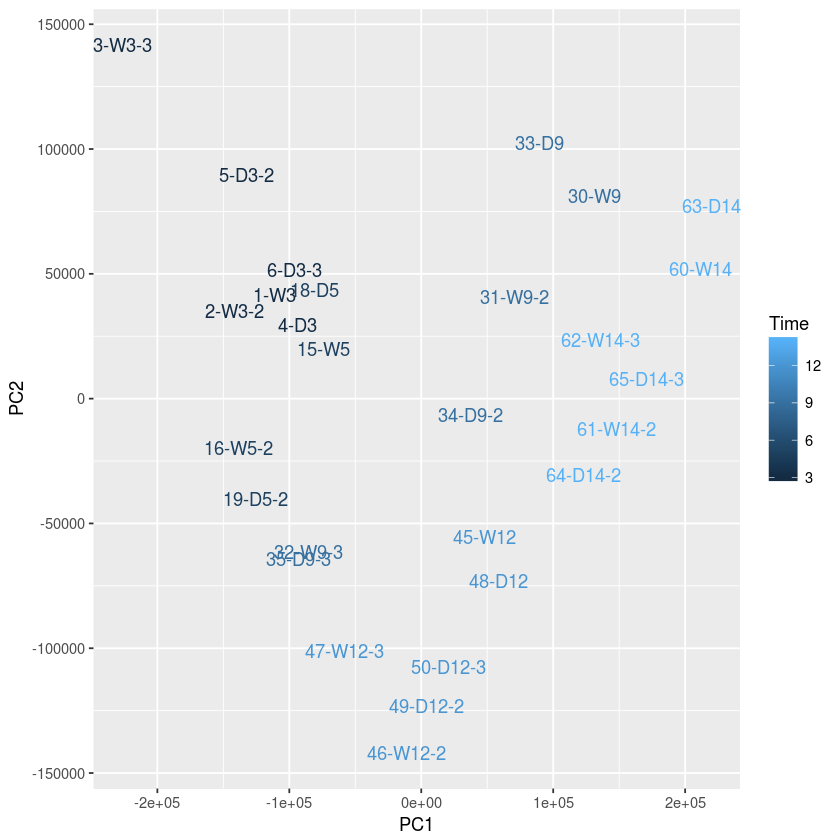

In [12]:
plot_pca(so.D, color_by = 'Time',text_labels = TRUE,units='scaled_reads_per_base')

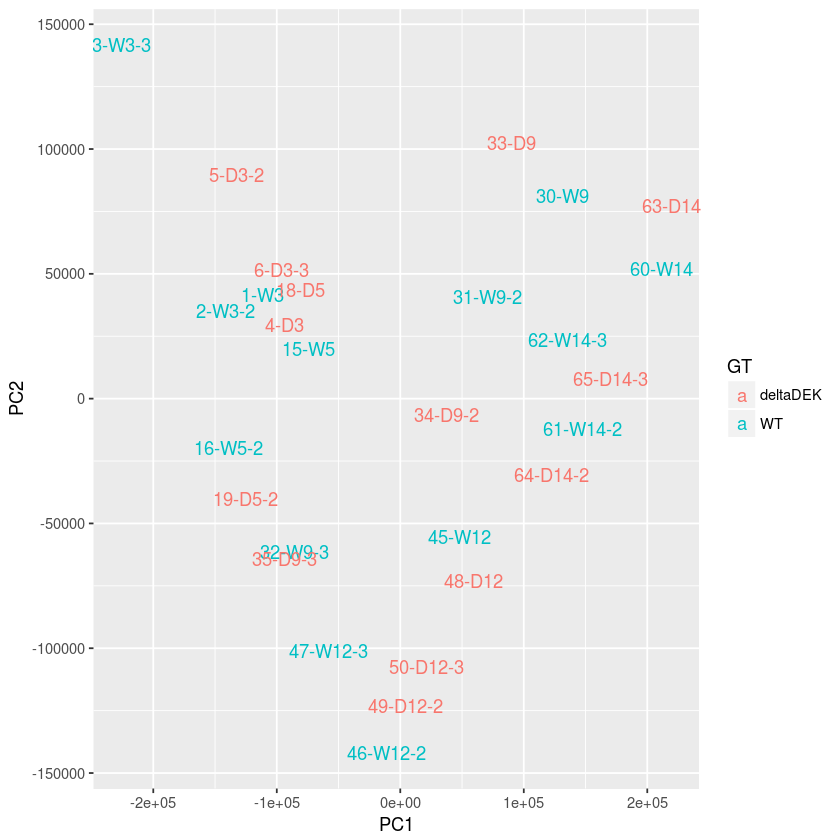

In [13]:
plot_pca(so.D, color_by = 'GT',text_labels = TRUE,units='scaled_reads_per_base')

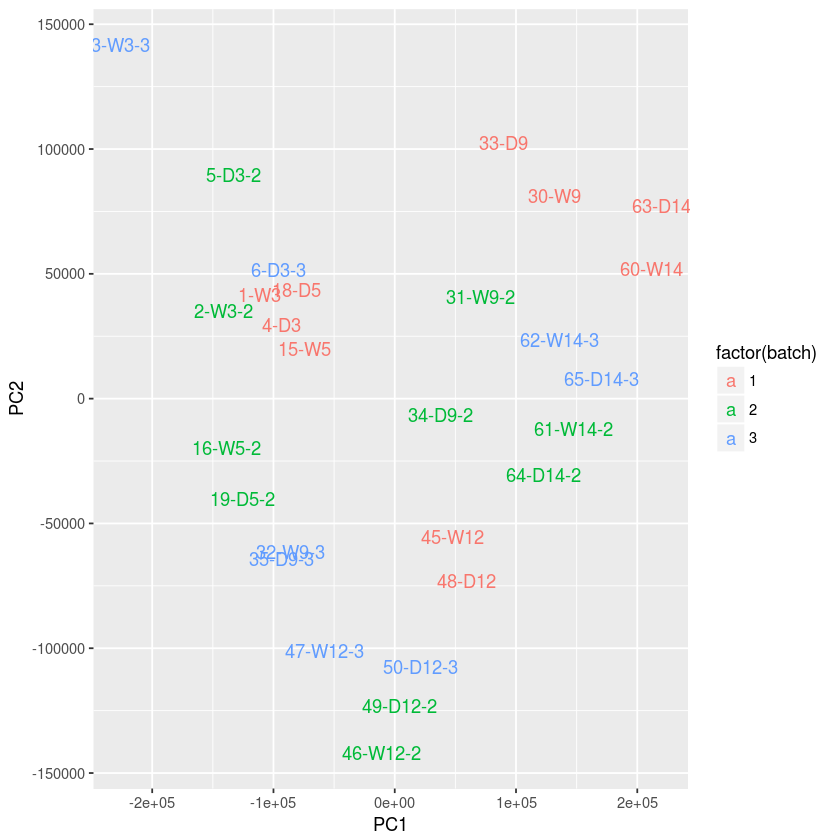

In [14]:
plot_pca(so.D, color_by = 'factor(batch)',text_labels = TRUE,units='scaled_reads_per_base',use_filtered=TRUE)

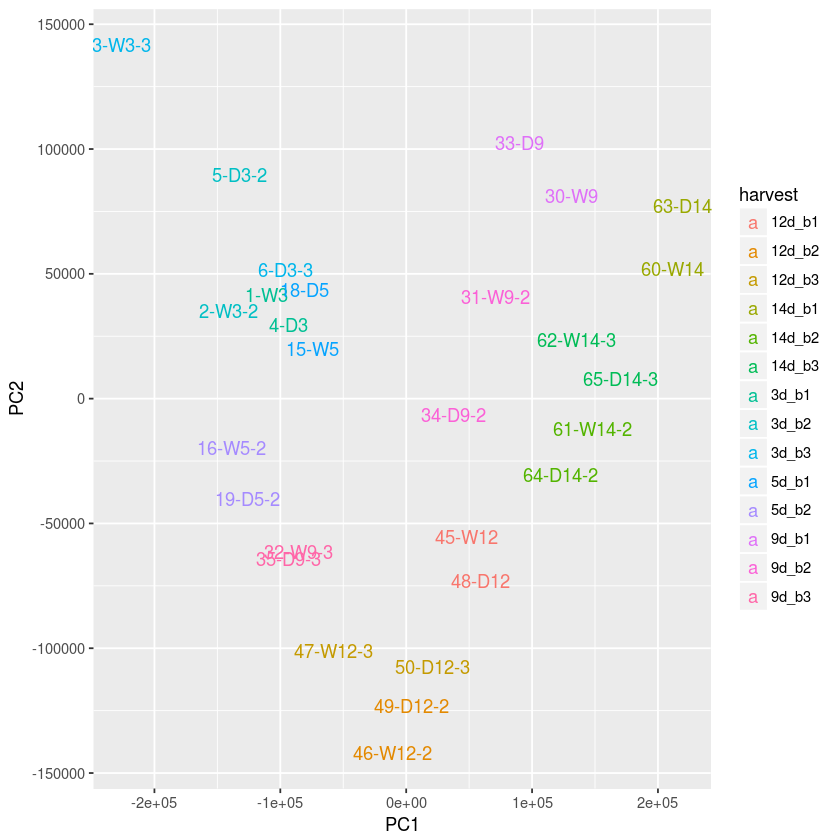

In [15]:
plot_pca(so.D, color_by = 'harvest',text_labels = TRUE,units='scaled_reads_per_base',use_filtered=TRUE)

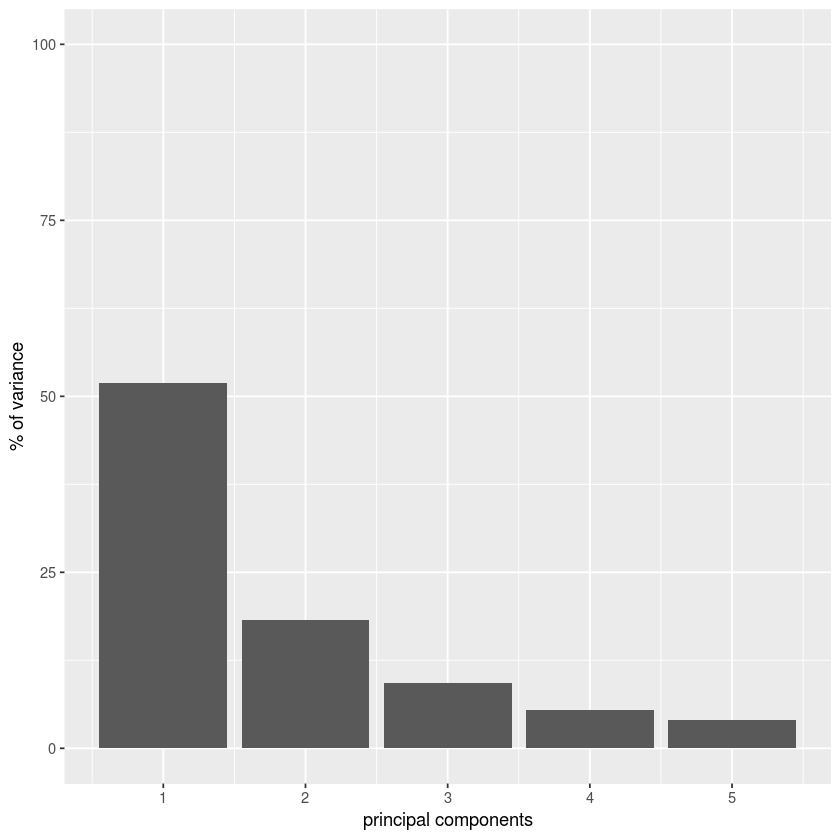

In [47]:
plot_pc_variance(so.D,units='scaled_reads_per_base')

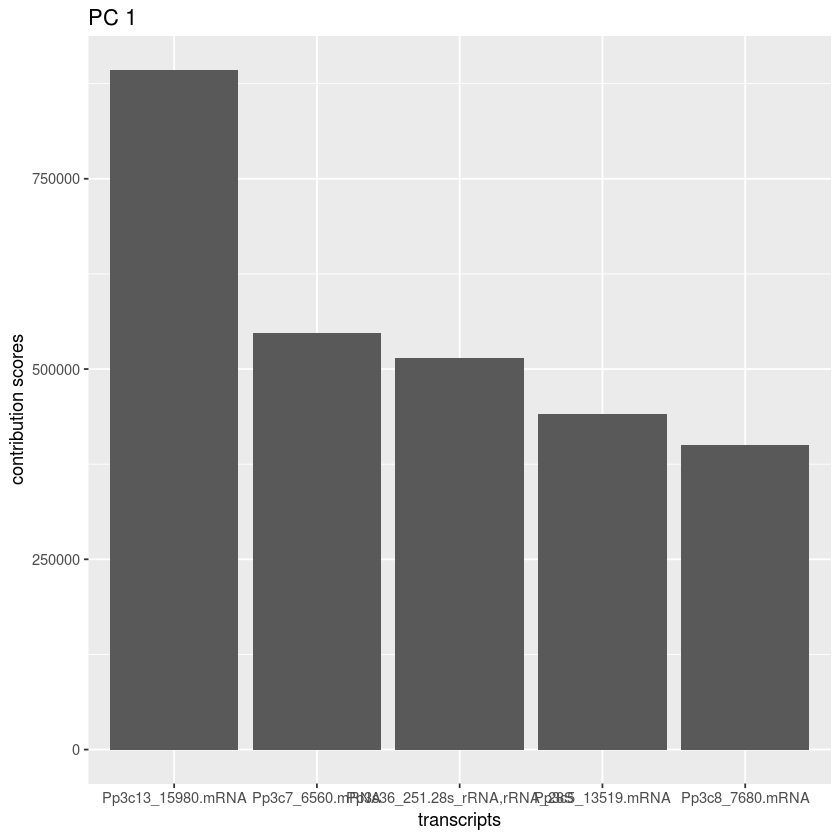

In [16]:
plot_loadings(so.D, pc_input = 1,units='scaled_reads_per_base')

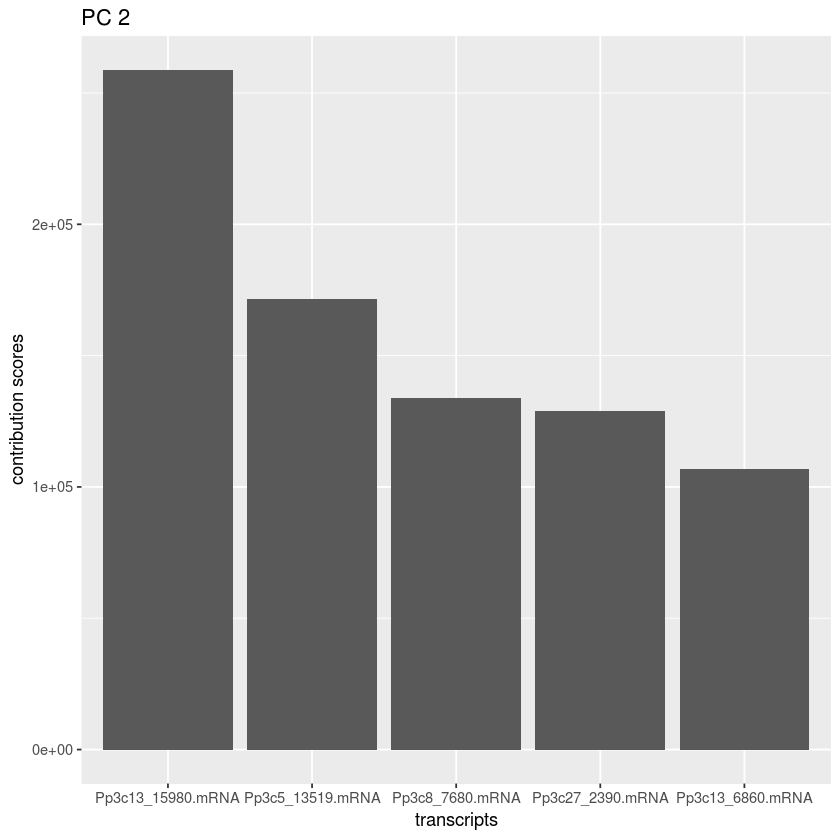

In [17]:
plot_loadings(so.D, pc_input = 2,units='scaled_reads_per_base')

Warning message:
“'switch' is deprecated.
Use 'strip.position' instead.
See help("Deprecated")”

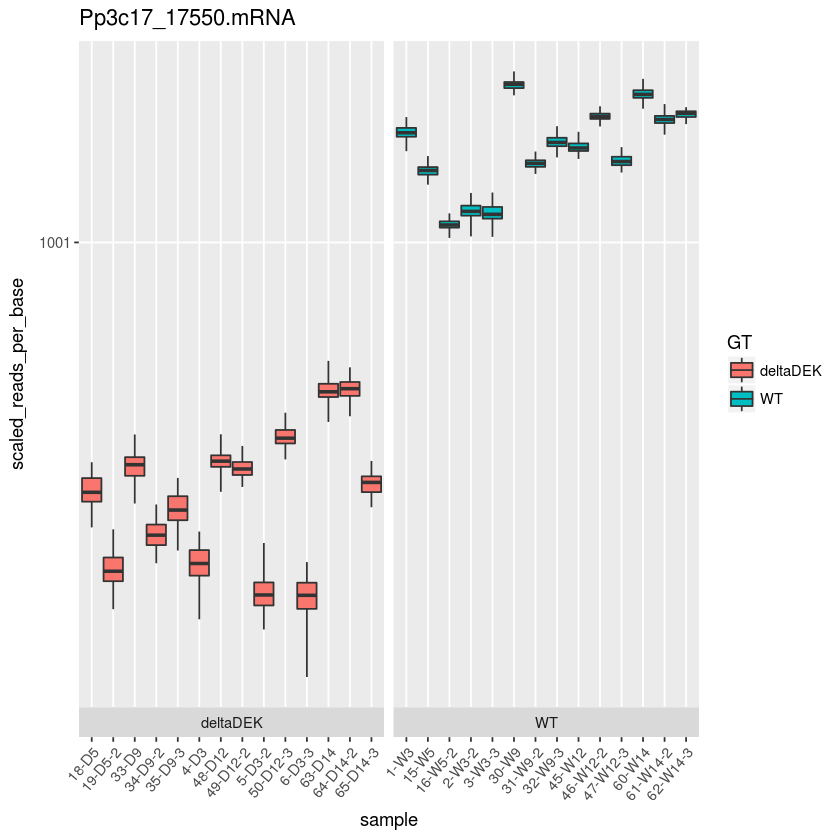

In [18]:
plot_bootstrap(so.D, 'Pp3c17_17550.mRNA', color_by = 'GT',units='scaled_reads_per_base') + scale_y_continuous(trans = "mylog10")

Warning message:
“'switch' is deprecated.
Use 'strip.position' instead.
See help("Deprecated")”

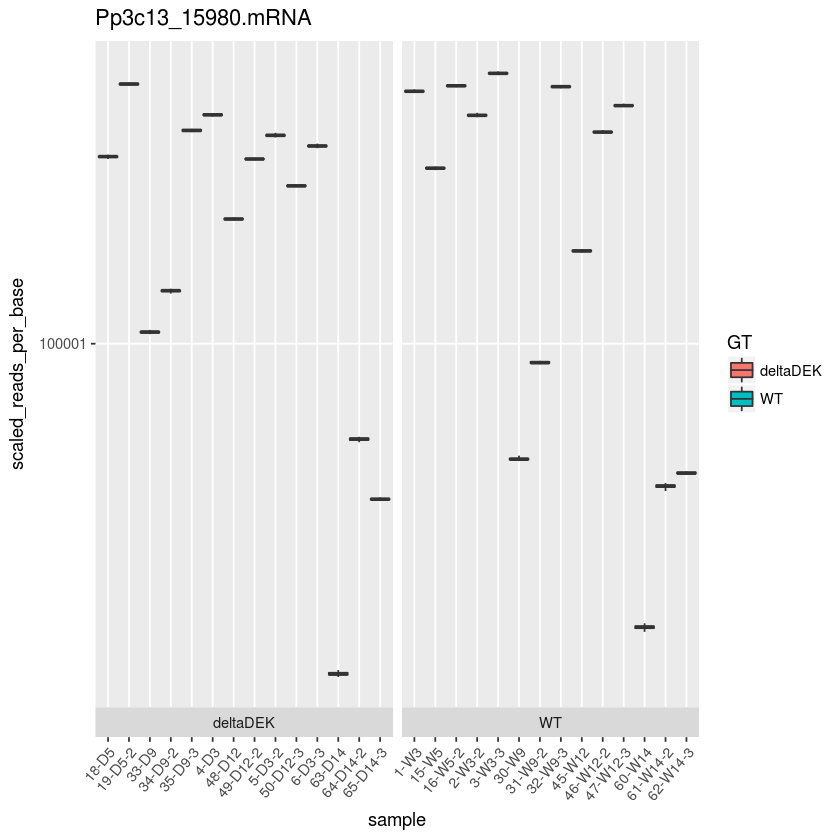

In [19]:
plot_bootstrap(so.D, 'Pp3c13_15980.mRNA', color_by = 'GT',units='scaled_reads_per_base') + scale_y_continuous(trans = "mylog10")

In [20]:
D$GT=relevel(factor(D$GT),"WT")

In [21]:
full_design <- model.matrix(formula(~ GT + ns(Time, df = 4)),data=D)
reduced_design <- model.matrix(formula(~ ns(Time, df = 4)),data=D)

In [25]:
full_design2 <- model.matrix(formula(~ GT + factor(batch) + ns(Time, df = 4)),data=D)
reduced_design2 <- model.matrix(formula(~ factor(batch) + ns(Time, df = 4)),data=D)

In [26]:
full_design2

,(Intercept),GTdeltaDEK,factor(batch)2,factor(batch)3,"ns(Time, df = 4)1","ns(Time, df = 4)2","ns(Time, df = 4)3","ns(Time, df = 4)4"
1,1,0,0,0,0.00000000,0.0000000,0.0000000,0.00000000
2,1,0,1,0,0.00000000,0.0000000,0.0000000,0.00000000
3,1,0,0,1,0.00000000,0.0000000,0.0000000,0.00000000
4,1,1,0,0,0.00000000,0.0000000,0.0000000,0.00000000
5,1,1,1,0,0.00000000,0.0000000,0.0000000,0.00000000
6,1,1,0,1,0.00000000,0.0000000,0.0000000,0.00000000
15,1,0,0,0,0.07407407,-0.1301890,0.4556617,-0.32547261
16,1,0,1,0,0.07407407,-0.1301890,0.4556617,-0.32547261
18,1,1,0,0,0.07407407,-0.1301890,0.4556617,-0.32547261
19,1,1,1,0,0.07407407,-0.1301890,0.4556617,-0.32547261


In [27]:
so.D= sleuth_fit(so.D,reduced_design2,fit_name="reduced2")

fitting measurement error models
shrinkage estimation
computing variance of betas


In [28]:
so.D= sleuth_fit(so.D, full_design2, fit_name = "full2")

fitting measurement error models
shrinkage estimation
computing variance of betas


In [29]:
so.D = sleuth_lrt(so.D, "reduced2", "full2")

In [53]:
models(so.D)

[  reduced2  ]
formula:  structure(c(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,  1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1,  0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,  0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,  1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0.0740740740740741, 0.0740740740740741,  0.0740740740740741, 0.0740740740740741, 0.603174603174603, 0.603174603174603,  0.603174603174603, 0.603174603174603, 0.603174603174603, 0.603174603174603,  0.0888888888888889, 0.0888888888888889, 0.0888888888888889, 0.0888888888888889,  0.0888888888888889, 0.0888888888888889, 0, 0, 0, 0, 0, 0, 0,  0, 0, 0, 0, 0, -0.130189045660703, -0.130189045660703, -0.130189045660703,  -0.130189045660703, 0.209559381722464, 0.209559381722464, 0.209559381722464,  0.209559381722464, 0.209559381722464, 0.209559381722464, 0.587464387464387,  0.587464387464387, 0.587464387464387, 0.587464387464387, 0.587464387464387,  0.587464387464387, -0.128205128205128, -0

In [54]:
so.D = sleuth_wt(so.D, 'GTdeltaDEK', which_model = "full2")

Warning message:
“Removed 1 rows containing missing values (geom_point).”

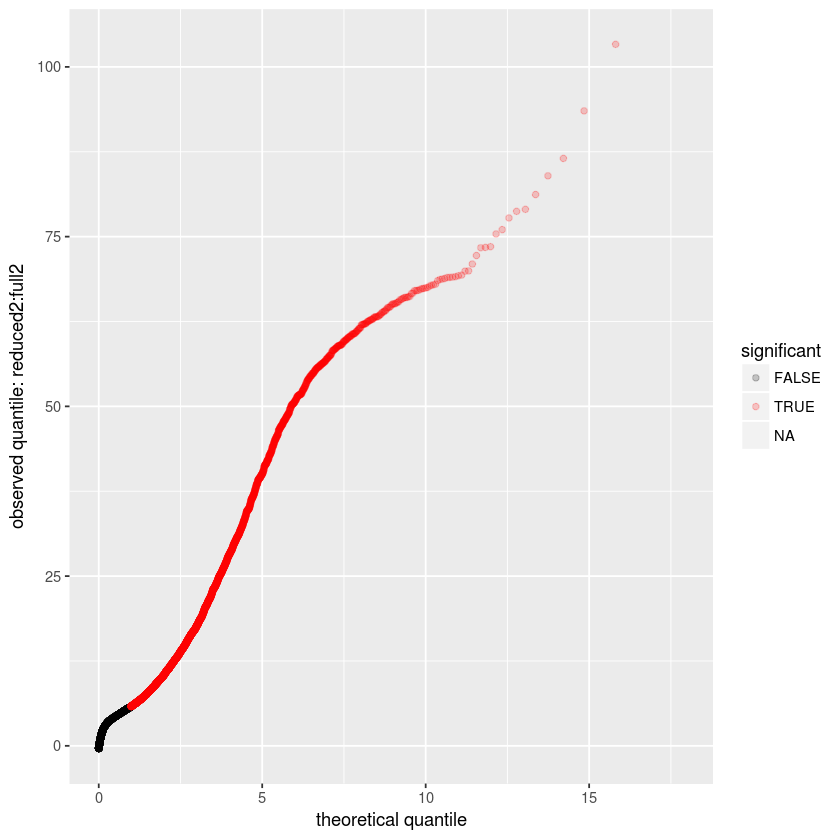

In [55]:
plot_qq(so.D, test = 'reduced2:full2', test_type = 'lrt', sig_level = 0.05)

Warning message:
“Removed 1 rows containing missing values (geom_path).”

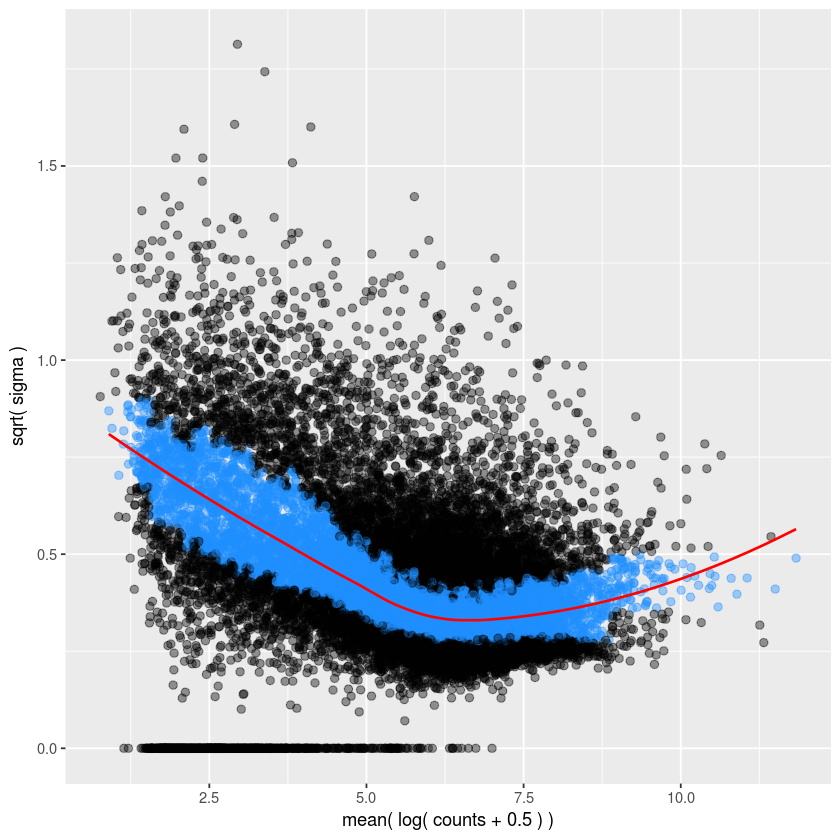

In [56]:
plot_mean_var(so.D,which_model="full2")

In [61]:
tt=sleuth_results(so.D,'GTdeltaDEK','wt',which_model="full2" ,show_all = FALSE,rename_cols=FALSE)
tt.sig= dplyr::filter(tt, qval < 0.05)
nrow(tt.sig)
table(tt.sig$b>0)

[1] 4332


FALSE  TRUE 
 2069  2263 

In [36]:
lrt_results= sleuth_results(so.D, 'reduced2:full2', test_type = 'lrt',show_all=TRUE)

In [65]:
o=na.omit(merge(lrt_results,tt,by="target_id",suffixes=c(".lrt",".wt")))
o=o[order(-o$b,-o$test_stat),]
table(o$b>0)
head(o[o$b>0,])


FALSE  TRUE 
11078 10347 

,target_id,test_stat,pval.lrt,qval.lrt,rss,sigma_sq.lrt,tech_var,mean_obs.lrt,var_obs.lrt,sigma_sq_pmax,⋯,pval.wt,qval.wt,b,se_b,mean_obs.wt,var_obs.wt,sigma_q_sq,sigma_sq.wt,smooth_sigma_sq.wt,smooth_sigma_sq_pmax
21311,Pp3s51_30.mRNA,40.26817,2.213864e-10,8.849259e-09,218.17005,8.851291,1.53775926,2.593606,9.403040,8.851291,⋯,6.217781e-16,2.617209e-14,4.885203,0.6042325,2.593606,9.403040,1.53775926,1.0179189,0.15970332,1.0179189
6369,Pp3c16_14660.mRNA,20.66664,5.466003e-06,7.854400e-05,188.51765,7.625211,1.35181972,3.811311,9.247169,7.625211,⋯,2.225787e-06,3.327808e-05,3.771554,0.7970718,3.811311,9.247169,1.35181972,3.0954445,0.07163868,3.0954445
2843,Pp3c11_3860.mRNA,42.74742,6.228405e-11,2.785879e-09,100.56903,4.622554,0.16644683,5.821599,5.825000,4.622554,⋯,1.130569e-17,5.382763e-16,3.359506,0.3924745,5.821599,5.825000,0.16644683,0.9118068,0.01471556,0.9118068
16756,Pp3c4_4250.mRNA,65.32033,6.366135e-16,2.573480e-13,85.27525,4.024567,0.03615983,4.412478,4.480623,4.024567,⋯,5.631073e-43,4.825830e-40,3.318984,0.2415083,4.412478,4.480623,0.03615983,0.3721240,0.04561335,0.3721240
2961,Pp3c11_7530.mRNA,54.82848,1.315211e-13,1.246917e-11,85.08144,3.961294,0.09020323,4.829656,5.278178,3.961294,⋯,1.035344e-28,1.540968e-26,3.234433,0.2909410,4.829656,5.278178,0.09020323,0.5023236,0.03284549,0.5023236
7105,Pp3c17_12600.mRNA,69.33284,8.317303e-17,9.271189e-14,76.37560,3.562089,0.07484434,3.604761,3.909355,3.562089,⋯,5.352775e-50,1.146832e-46,3.163148,0.2127550,3.604761,3.909355,0.07484434,0.2420085,0.08287169,0.2420085


In [103]:
m1=read.delim("../analysis//cosmoss_V3.3.mRNA_ncRNA.tx2gene.full.gene_wise.tsv",sep="\t",stringsAsFactors=FALSE)
names(m1)[1]="target_id"
head(m1)

target_id,spectype,TXNAME,GENEID,TYPE,Alias,support,origin,isoform,longest_transcript,has_evidence,class,has_protein_homology,has_proteomics_support,encoded_by,is_filtered
Pp3c10_10000.tRNA,tRNA,Pp3c10_10000V3.1,Pp3c10_10000,ncRNA,"tRNA,Pp3c10_10000N1.1,Pp3c10_10000V1.1,N1.Chr10.ncRNA.54,tRNA.717",supported_by_sequence_similarity,RFAM11.Infernal1.1,major,true,false,tRNA,false,false,ncRNA_gene,false
Pp3c10_10040.mRNA,mRNA,"Pp3c10_10040V3.2,Pp3c10_10040V3.3,Pp3c10_10040V3.5,Pp3c10_10040V3.6,Pp3c10_10040V3.4,Pp3c10_10040V3.1",Pp3c10_10040,mRNA,"PAC4GC:5701563,Pp3c10_10040J4.1,Pp1s58_283V6.2,PAC4GC:5701564,P2.evm.model.Chr10.357,Pp3c10_10040J5.3,Pp3c10_10040J5.4,Pp3c10_10040V1.1,P2.Chr10.mRNA.3452,Phpatv32029367m,PAC4GC:5701565,Phpatv32029366m,PAC4GC:5701561,Pp3c10_10040J5.2,Pp1s58_283V6.1,Pp3c10_10040J5.1,Phpatv32029364m,Pp3c10_10040P2.1,Phpatv32029365m,Phpatv32029363m,P2.EVM%20prediction%20Chr10.357,Pp3c10_10040P2.2,PAC4GC:5701562",supported_by_EST_or_cDNA,NA,"alternative,major","true,false",true,NA,true,false,protein_coding_gene,false
Pp3c10_10090.mRNA,mRNA,"Pp3c10_10090V3.2,Pp3c10_10090V3.1",Pp3c10_10090,mRNA,"Phpatv32029368m,Pp3c10_10090V1.1,J3.Chr10.mRNA.912,J3.Phypav3.0.4_pg25522.valid.m1,J3.7022241,Pp3c10_10090J4.1,Pp3c10_10090J3.1,PAC4GC:5700224,pred.234120000946",supported_by_EST_or_cDNA,NA,"major,alternative","false,true",true,NA,false,false,protein_coding_gene,false
Pp3c10_10095.C_D_box_snoRNA,C_D_box_snoRNA,Pp3c10_10095V3.1,Pp3c10_10095,ncRNA,"Chr10.snoRNA.21,snoR64.1,Chr10.snoRNA.22,Pp3c10_10095V1.1,Chr10.snoRNA.32,Chr10.snoRNA.23,snoR64,N1.Chr10.ncRNA.55,Pp3c10_10095N1.1,Chr10.snoRNA.33,snR72%2FZ2,snR58",supported_by_sequence_similarity,"RFAM11.Infernal1.1,snoscan-0.9b",major,true,true,C_D_box_snoRNA,false,false,ncRNA_gene,false
Pp3c10_100.ncRNA,ncRNA,Pp3c10_100V3.1,Pp3c10_100,ncRNA,"Pp3c10_100V1.1,Pp3c10_100P0.1,asmbl_110854",supported_by_EST_or_cDNA,NA,major,true,true,NA,false,false,ncRNA_gene,false
Pp3c10_10100.mRNA,mRNA,"Pp3c10_10100V3.1,Pp3c10_10100V3.4,Pp3c10_10100V3.2,Pp3c10_10100V3.5,Pp3c10_10100V3.3",Pp3c10_10100,mRNA,"Pp3c10_10100J5.3,Phpatv32029369m,PAC4GC:5701591,PAC4GC:5701593,Pp1s58_289V6.1_29440,PAC4GC:5701592,Phpatv32029370m,Pp3c10_10100V1.1,Phpatv32029372m,Pp3c10_10100J5.1,Pp3c10_10100J5.2,C1.Pp1s58_289V6.1,Phpatv32029371m,C1.560145,PAC4GC:5701590,Pp1s58_289V6.1,C1.Chr10.mRNA.576,Pp3c10_10100J4.1,Pp3c10_10100C1.1",supported_by_EST_or_cDNA,NA,"alternative,major","true,false",true,NA,true,false,protein_coding_gene,false


In [86]:
m2=read.delim("../analysis//cosmoss.genonaut.V3.3.gene_and_protein_names.tsv",sep="\t",col.names=c("GENEID","name"),stringsAsFactors=FALSE)
head(m2)

GENEID,name
Pp3c10_13310,XTH28
Pp3c10_13800,"CHR1545,chr1545"
Pp3c10_13960,"CHLH1,chlh2,CHLH2,chlh1"
Pp3c10_13970,"chlh1,CHLH2,chlh2,CHLH1"
Pp3c10_14020,"raba53,RABA53"
Pp3c10_14800,"ppr_20,PPR_20"


In [98]:
m3=read.delim("../analysis//Ppatens_318_v3.3.defline.txt",sep="\t",col.names=c("GENEID","source","defline"),stringsAsFactors=FALSE)
m3$GENEID=gsub("V3\\.\\d+","",m3$GENEID,perl=TRUE)
head(m3)

GENEID,source,defline
Pp3c10_10220,pdef,"K00615 - transketolase (E2.2.1.1, tktA, tktB) (1 of 4)"
Pp3c10_10230,pdef,K14763 - H/ACA ribonucleoprotein complex non-core subunit NAF1 (NAF1) (1 of 1)
Pp3c10_10240,pdef,PTHR10641:SF599 - MYB TRANSCRIPTION FACTOR-RELATED (1 of 3)
Pp3c10_10270,pdef,2.4.1.12 - Cellulose synthase (UDP-forming) / UDP-glucose-cellulose glucosyltransferase (1 of 17)
Pp3c10_10460,pdef,"K03320 - ammonium transporter, Amt family (amt, AMT, MEP) (1 of 12)"
Pp3c10_10490,pdef,"PTHR11177:SF167 - RHODANESE-LIKE DOMAIN-CONTAINING PROTEIN 4, CHLOROPLASTIC (1 of 3)"


In [101]:
m4=read.delim("../analysis//Physcomitrella_patens.TAP_annotation.6.tsv",sep="\t")
names(m4)[2]="GENEID"
head(m4)

superfamily,GENEID,inferred_by_rule,TAP_class
BSD domain containing,Pp3c11_12590V3,True,PT
BSD domain containing,Pp3c1_21290V3,True,PT
BSD domain containing,Pp3c20_12230V3,True,PT
BSD domain containing,Pp3c23_10600V3,True,PT
BSD domain containing,Pp3c24_7080V3,True,PT
BSD domain containing,Pp3c26_14480V3,True,PT


In [115]:
O=merge(o,m1,by="target_id")
nrow(o)
nrow(O)
O=merge(O,m2,by="GENEID",all.x=TRUE)
nrow(O)
O=merge(O,m3,by="GENEID",all.x=TRUE)
nrow(O)
O=merge(O,m4,by="GENEID",all.x=TRUE)
nrow(O)
O=O[order(-O$test_stat),]
head(O)

[1] 21425

[1] 21425

[1] 21425

[1] 21425

[1] 21425

,GENEID,target_id,test_stat,pval.lrt,qval.lrt,rss,sigma_sq.lrt,tech_var,mean_obs.lrt,var_obs.lrt,⋯,has_protein_homology,has_proteomics_support,encoded_by,is_filtered,name,source,defline,superfamily,inferred_by_rule,TAP_class
7310,Pp3c17_17550,Pp3c17_17550.mRNA,103.32249,2.848017e-24,6.101877e-20,15.941491,0.756779,0.002339578,6.562568,0.6341631,⋯,true,"false,true",protein_coding_gene,false,DEK1,pdef,3.4.22.54 - Calpain-3 / Muscle-specific calcium-activated neutral protease 3 (1 of 2),NA,NA,NA
11580,Pp3c21_8110,Pp3c21_8110.mRNA,93.52852,4.003886e-22,4.289163e-18,61.686864,2.892995,0.044474449,5.370789,3.1550372,⋯,true,false,protein_coding_gene,false,NA,NA,NA,NA,NA,NA
6722,Pp3c16_24530,Pp3c16_24530.mRNA,86.52013,1.383220e-20,9.878498e-17,29.906634,1.418795,0.005330678,6.773956,2.2938401,⋯,true,false,protein_coding_gene,false,NA,NA,NA,NA,NA,NA
757,Pp3c1_32020,Pp3c1_32020.mRNA,83.96443,5.037581e-20,2.698254e-16,5.634233,0.265381,0.002915756,6.257943,0.2313600,⋯,true,false,protein_coding_gene,false,NA,pdef,PTHR14791//PTHR14791:SF28 - BOMB/KIRA PROTEINS // SUBFAMILY NOT NAMED (1 of 11),NA,NA,NA
2263,Pp3c11_12520,Pp3c11_12520.mRNA,81.19679,2.043237e-19,8.755270e-16,69.382622,3.207374,0.096559959,4.031027,4.1861024,⋯,true,false,protein_coding_gene,false,NA,pdef,PF14368 - Probable lipid transfer (LTP_2) (1 of 63),NA,NA,NA
20268,Pp3c8_8070,Pp3c8_8070.mRNA,79.02022,6.147753e-19,2.186701e-15,65.920944,3.015494,0.123598554,3.174862,3.0669644,⋯,true,false,protein_coding_gene,false,NA,pdef,K00430 - peroxidase (E1.11.1.7) (1 of 54),NA,NA,NA


In [113]:
t(O[ O$target_id=='Pp3c17_17550.mRNA',])

,7310
GENEID,Pp3c17_17550
target_id,Pp3c17_17550.mRNA
test_stat,103.3225
pval.lrt,2.848017e-24
qval.lrt,6.101877e-20
rss,15.94149
sigma_sq.lrt,0.756779
tech_var,0.002339578
mean_obs.lrt,6.562568
var_obs.lrt,0.6341631


In [76]:
table(o$qval.lrt<0.05)
table(o$qval.wt<0.05)
table(o$qval.lrt<0.05,o$qval.wt<0.05)


FALSE  TRUE 
14602  6823 


FALSE  TRUE 
17093  4332 

       
        FALSE  TRUE
  FALSE 14602     0
  TRUE   2491  4332

In [117]:
head(O[,c("target_id","test_stat","b","qval.lrt","qval.wt","name","superfamily","TAP_class","defline")],n=50)

,target_id,test_stat,b,qval.lrt,qval.wt,name,superfamily,TAP_class,defline
7310,Pp3c17_17550.mRNA,103.32249,-1.4903790,6.101877e-20,8.105872e-170,DEK1,NA,NA,3.4.22.54 - Calpain-3 / Muscle-specific calcium-activated neutral protease 3 (1 of 2)
11580,Pp3c21_8110.mRNA,93.52852,2.9162090,4.289163e-18,4.989863e-118,NA,NA,NA,NA
6722,Pp3c16_24530.mRNA,86.52013,2.0200250,9.878498e-17,1.206114e-90,NA,NA,NA,NA
757,Pp3c1_32020.mRNA,83.96443,0.8758473,2.698254e-16,5.975513e-75,NA,NA,NA,PTHR14791//PTHR14791:SF28 - BOMB/KIRA PROTEINS // SUBFAMILY NOT NAMED (1 of 11)
2263,Pp3c11_12520.mRNA,81.19679,3.0616086,8.755270e-16,4.422621e-74,NA,NA,NA,PF14368 - Probable lipid transfer (LTP_2) (1 of 63)
20268,Pp3c8_8070.mRNA,79.02022,2.9877285,2.186701e-15,1.311739e-56,NA,NA,NA,K00430 - peroxidase (E1.11.1.7) (1 of 54)
603,Pp3c1_27500.mRNA,78.72340,2.7746806,2.186701e-15,8.557425e-57,NA,NA,NA,PTHR33210:SF8 - POLLEN OLE E 1 ALLERGEN AND EXTENSIN FAMILY PROTEIN (1 of 2)
6628,Pp3c16_21370.mRNA,77.75372,0.6098334,3.125997e-15,1.641590e-39,NA,NA,NA,"K12881 - THO complex subunit 4 (THOC4, ALY) (1 of 3)"
9560,Pp3c2_22630.mRNA,76.03059,-0.9200223,6.648995e-15,1.204504e-60,NA,NA,NA,PTHR10168:SF62 - GLUTAREDOXIN-C7-RELATED (1 of 2)
11493,Pp3c21_5540.mRNA,75.40157,-2.5149886,8.229021e-15,1.040300e-48,NA,NA,NA,PTHR21236:SF8 - INTEGRAL MEMBRANE YIP1 FAMILY PROTEIN (1 of 3)


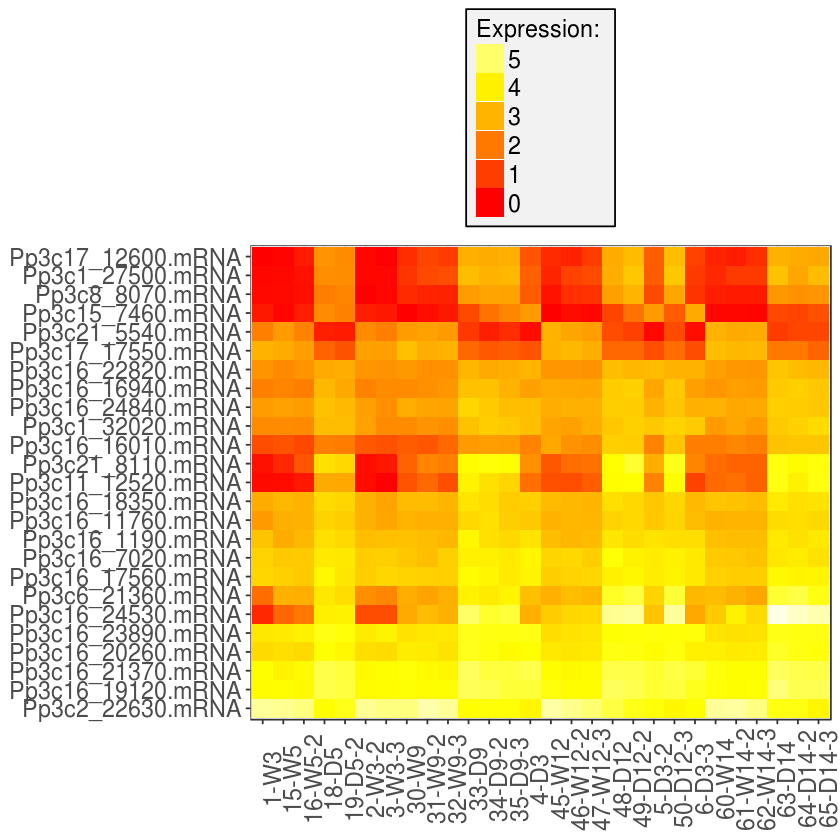

In [132]:
plot_transcript_heatmap(so.D, head(O, n = 25)$target_id)

In [138]:
subset(O,spectype=="pre_miRNA" & qval.lrt<0.1)[,c("target_id","test_stat","b","qval.lrt","qval.wt","Alias")]

,target_id,test_stat,b,qval.lrt,qval.wt,Alias
12054,Pp3c22_2794.pre_miRNA,11.375320,0.36851212,0.005175566,0.009088936,"MI0003499,Pp3c22_2794N1.1,MIR159.3,ppt-MIR319d,Pp3c22_2794V1.1,N1.Chr22.ncRNA.13,MIR159"
16675,Pp3c4_3072.pre_miRNA,7.999777,-0.95026016,0.021789739,0.043062081,"N1.Chr04.ncRNA.14,ppt-MIR1042,MI0006001,Pp3c4_3072V1.1,ppt-MIR1043,Pp3c4_3072V1.2,MI0006002,Pp3c4_3072N1.1,N1.Chr04.ncRNA.15,Pp3c4_3072N1.2"
7575,Pp3c17_2572.pre_miRNA,4.781754,-0.53850689,0.068877085,0.166213070,"MI0006015,N1.Chr17.ncRNA.13,Pp3c17_2572V1.1,ppt-MIR1056,Pp3c17_2572N1.1"
17880,Pp3c6_12422.pre_miRNA,4.220703,-0.08994455,0.081756089,0.529338601,"Pp3c6_12422N1.1,N1.Chr06.ncRNA.71,ppt-MIR419,Pp3c6_12422V1.1,MI0005670"
4384,Pp3c13_7201.pre_miRNA,4.153094,0.04622928,0.083369980,0.786124530,"MI0005966,Pp3c13_7201V1.1,ppt-MIR1025,Pp3c13_7201N1.1,N1.Chr13.ncRNA.30"


In [140]:
write.table(o,gzfile("comp.WT_vs_deltaDEK/dge.tsv.gz"),sep="\t",col.names=TRUE,row.names=FALSE,quote=FALSE)
write.table(O,gzfile("comp.WT_vs_deltaDEK/dge.full.tsv.gz"),sep="\t",col.names=TRUE,row.names=FALSE,quote=FALSE)